# Dataset
Предложенная таблица содержит данные по 5000 клиентов:
* No - Порядковый номер клиента
* predictor1-5* - Переменные (предикторы) по которым необходимо построить модель. Все переменные являются количественными.
* target - Целевая бинарная переменная, обозначающая факт дефолта клиента  
\*predictor 3 содержит пропущенные значения, выбор метода их обработки остается за соискателем.

# Задача
Необходимо построить модель, позволяющую предсказывать вероятность дефолта клиента. 

# Setup

In [1]:
!pip install -U imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn import metrics

from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin

from imblearn import pipeline as imb_pipe
from imblearn.under_sampling import RandomUnderSampler, NearMiss, OneSidedSelection, NeighbourhoodCleaningRule
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [3]:
df = pd.read_csv('default.csv', index_col=0)

df.columns = df.columns.str.replace(' ', '_')

df.head()

,predictor_1,predictor_2,predictor_3,predictor_4,predictor_5,target
No,,,,,,
1,12423,710,441.5,5,4631.0,1
2,13983,1106,NaN,3,4256.0,1
3,15520,1276,391.5,1,4397.0,0
4,29535,1106,NaN,1,3772.0,1
5,26154,976,315.0,5,2445.0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10,000
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   predictor_1  10000 non-null  int64  
 1   predictor_2  10000 non-null  int64  
 2   predictor_3  8087 non-null   float64
 3   predictor_4  10000 non-null  int64  
 4   predictor_5  10000 non-null  float64
 5   target       10000 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 546.9+ KB


# EDA

In [5]:
df.describe()

,predictor_1,predictor_2,predictor_3,predictor_4,predictor_5,target
count,10000.000000,10000.000000,8087.000000,10000.000000,10000.000000,10000.000000
mean,20107.924800,1123.810200,368.662174,3.490400,2518.598750,0.195500
std,12679.903068,146.337209,68.536786,3.827607,1447.114231,0.396605
min,7.000000,564.000000,62.000000,1.000000,0.500000,0.000000
25%,9651.250000,1050.000000,325.000000,1.000000,1261.375000,0.000000
50%,18850.000000,1106.000000,377.500000,3.000000,2536.500000,0.000000
75%,28010.500000,1214.000000,419.000000,5.000000,3765.125000,0.000000
max,49996.000000,1450.000000,512.500000,49.000000,5000.000000,1.000000


In [6]:
df.target.value_counts(normalize=True)

0    0.8045
1    0.1955
Name: target, dtype: float64

<AxesSubplot:>

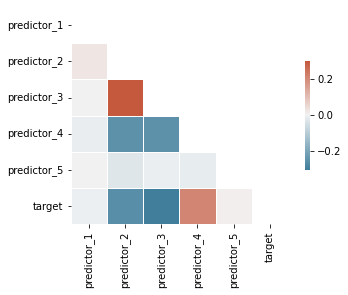

In [7]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

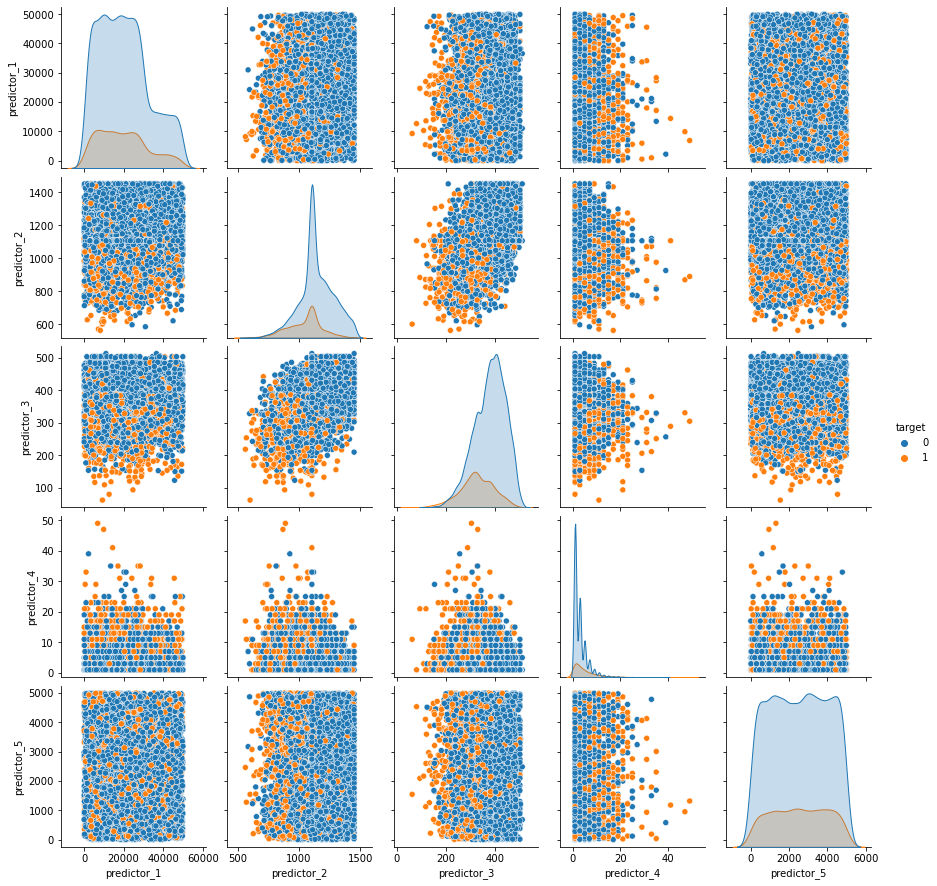

In [8]:
sns.pairplot(df, hue='target')

# Train/Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('target', axis=1), df.target, test_size=0.33, random_state=42)

# Baseline

In [10]:
def report_score(estimator, title='', label=''):
    """
    Строит отчет:
        - График ROC-AUC для test
        - Mean cross-val ROC-AUC score
        - Test ROC-AUC score

    estimator: модель или pipeline
    title: Заголовок графика
    X_train, y_train, X_test, y_test: df из global scope
    
    return
    cv_train_score: mean ROC-AUC train
    test_score: ROC-AUC test
    """

    estimator.fit(X_train, y_train)

    cv_train_score = cross_val_score(estimator,
                                     X_train,
                                     y_train,
                                     scoring='roc_auc',
                                     cv=5,
                                     n_jobs=-1,
                                     error_score='raise').mean()

    y_predict = estimator.predict_proba(X_test)
    test_score = metrics.roc_auc_score(y_true=y_test, y_score=y_predict[:, 1])

    # ROC-AUC plot
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_predict[:, 1])
    plt.plot(
        fpr,
        tpr,
        label=f'test: {round(test_score, 4)} cv_train: {round(cv_train_score, 4)} {label}',
        alpha=0.7
    )
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.title(f'ROC-AUC {title}')
    plt.legend(bbox_to_anchor=(1.04, 1))
   
    return cv_train_score, test_score

[(0.7320231372303457, 0.7329744768010177, 'LogisticRegression'),
 (0.7284923439157921, 0.7351582738051319, 'RandomForestClassifier'),
 (0.7158807575613625, 0.7221790381798412, 'DecisionTreeClassifier'),
 (0.7093128399768062, 0.7157469037613586, 'GradientBoostingClassifier'),
 (0.7065088828093493, 0.7332227135479494, 'SGDClassifier'),
 (0.510820668519514, 0.6082761216268544, 'SVC')]

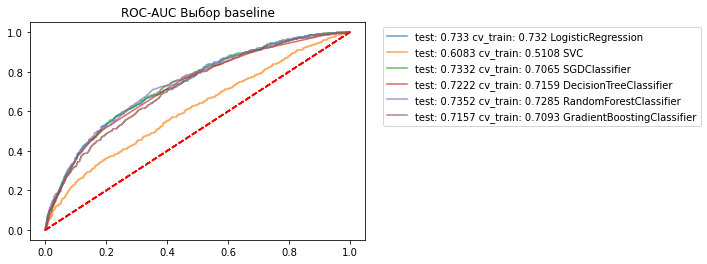

In [11]:
classifiers = [
    LogisticRegression(),
    SVC(kernel='linear', C=0.025, probability=True),
    SGDClassifier(loss='log', penalty='l2', max_iter=500),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10),
    GradientBoostingClassifier(n_estimators=300,
                               learning_rate=0.2,
                               max_depth=2, random_state=42)
]

scores = []
for clf in classifiers:
    pipe = Pipeline(steps=[
        ('fill_na', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('classifier', clf),
    ])
    
    clf_name = clf.__class__.__name__
    train_score, test_score = report_score(pipe, title='Выбор baseline', label=clf_name)
    scores.append((train_score, test_score, clf_name))

sorted(scores, reverse=True)

# Формирование pipeline
Возьмем в работу алгоритм LogisticRegression. Сравним разные методы заполнения пропусков, сделаем подбор параметров поиском по сетке, и попробуем выравнять баланс классов через веса/оверсемплинг/андерсемплинг.
## Заполнение пропусков

[(0.732, 0.733, 'SimpleImputer()'),
 (0.7316, 0.733, 'IterativeImputer(random_state=0)'),
 (0.7311, 0.7317, 'KNNImputer(n_neighbors=2)'),
 (0.7308, 0.7323, "SimpleImputer(strategy='median')"),
 (0.7299, 0.7317, "SimpleImputer(strategy='most_frequent')"),
 (0.7148, 0.7122, "SimpleImputer(strategy='constant')"),
 (0.7029, 0.7046, "LinearRegressionImputer(feature='predictor_3')")]

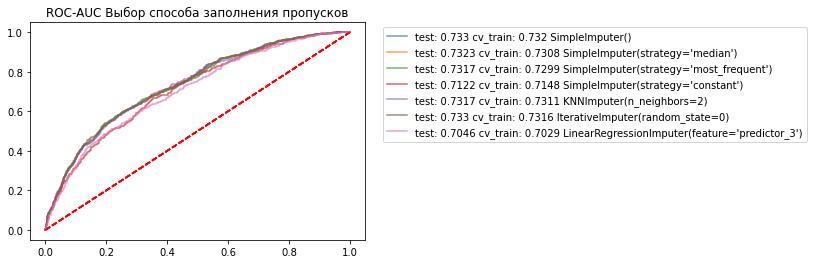

In [12]:
class LinearRegressionImputer(BaseEstimator, TransformerMixin):
    """
    Предоставляет трансформер данных, заполняющий 
    пропуски значений с помощью алгоритма линейной регрессии.
    
    Целевая переменная - переменная с пропусками
    train - все данные без пропусков
    predict на данные с пропусками   
    """
    def __init__(self, feature):
        self.reg = LinearRegression()
        self.feature = feature

    def fit(self, X, y=None):
        full_data = X[~X[self.feature].isna()]

        self.reg.fit(full_data.drop(self.feature, axis=1),
                     full_data[self.feature])
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
         
        predicted = self.reg.predict(df.drop(self.feature, axis=1))
        df[self.feature] = predicted
        
        return df      


imputers = [    
    SimpleImputer(strategy='mean'),
    SimpleImputer(strategy='median'),
    SimpleImputer(strategy='most_frequent'),
    SimpleImputer(strategy='constant'),
    KNNImputer(n_neighbors=2),
    IterativeImputer(random_state=0),
    LinearRegressionImputer('predictor_3')
]

scores = []
for imputer in imputers:
    pipe = Pipeline(steps=[
        ('fill_na', imputer),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(solver='liblinear', random_state=42)),
    ])

    train_score, test_score = report_score(pipe, title='Выбор способа заполнения пропусков', label=pipe['fill_na'])
    scores.append((round(train_score, 4), round(test_score, 4), str(pipe['fill_na'])))

sorted(scores, reverse=True)

## GridSearch и feature selection

[{'classifier__C': 0.01,
  'classifier__class_weight': 'balanced',
  'classifier__penalty': 'l2',
  'classifier__solver': 'liblinear',
  'select_features__k': 3},
 {'classifier__C': 0.01,
  'classifier__class_weight': 'balanced',
  'classifier__penalty': 'l2',
  'classifier__solver': 'lbfgs',
  'select_features__k': 3}]

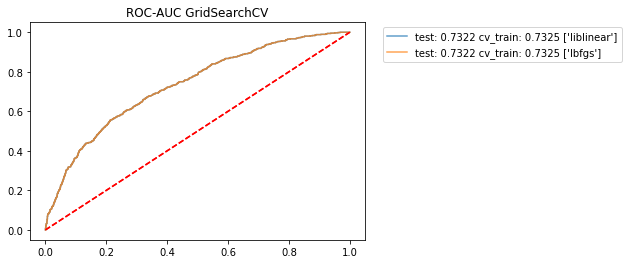

In [14]:
common_params = {    
    'classifier__class_weight': ['balanced', None],
    'classifier__C': [0.01, 0.1, 0.5, 1],
    'select_features__k': [2, 3, 4, 5]
}

# solvers поддерживают не все penalty
liblinear_params = {
    **common_params,
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

lbfgs_params = {
    **common_params,
    'classifier__penalty': ['l2', 'none'],
    'classifier__solver': ['lbfgs']
}

best_params = []
for params in [liblinear_params, lbfgs_params]:
    pipe = Pipeline(steps=[
        ('fill_na', KNNImputer(n_neighbors=2)),
        ('scaler', StandardScaler()),
        ('select_features', SelectKBest()),
        ('classifier', LogisticRegression(random_state=42)),
    ])

    gs = GridSearchCV(pipe, params, scoring='roc_auc', cv=5, n_jobs=-1)
    gs.fit(X_train, y_train)
    best_params.append(gs.best_params_)
    
    report_score(gs, title='GridSearchCV', label=params['classifier__solver'])

best_params

In [15]:
params = {
    'C': 0.5,
    'class_weight': 'balanced',
    'penalty': 'l2',
    'solver': 'lbfgs'
}

## Семплирование

[(0.7328, 0.7323, SMOTETomek(n_jobs=-1, sampling_strategy=1)),
 (0.7325, 0.732, OneSidedSelection(n_jobs=-1, random_state=0)),
 (0.7324, 0.7322, RandomUnderSampler(random_state=0)),
 (0.7314, 0.731, NeighbourhoodCleaningRule(n_jobs=-1)),
 (0.7314, 0.7307, NearMiss(n_jobs=-1, version=3)),
 (0.7312, 0.7314, SMOTEENN(n_jobs=-1, random_state=0, sampling_strategy=1))]

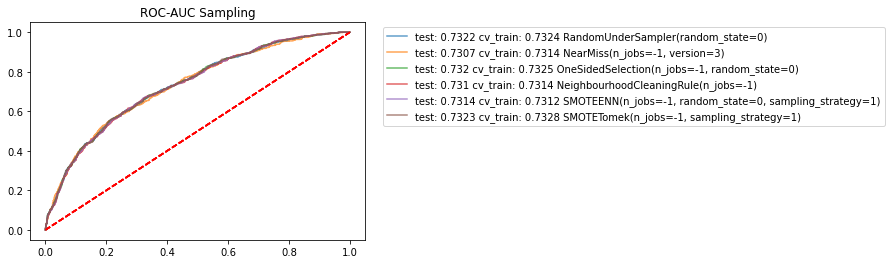

In [16]:
samplers = [
    RandomUnderSampler(random_state=0),
    NearMiss(version=3, n_neighbors_ver3=3, n_jobs=-1),
    OneSidedSelection(random_state=0, n_jobs=-1),
    NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5,
                              n_jobs=-1),
    SMOTEENN(sampling_strategy=1, random_state=0, n_jobs=-1),
    SMOTETomek(sampling_strategy=1, n_jobs=-1)
]

scores = []
for sampler in samplers:
    pipe = imb_pipe.Pipeline(steps=[
        ('fill_na', KNNImputer(n_neighbors=2)),
        ('sampler', sampler),
        ('scaler', StandardScaler()),
        ('select_features', SelectKBest(k=3)),
        ('classifier', LogisticRegression(**params, random_state=42)),
    ])

    train_score, test_score = report_score(pipe, title='Sampling', label=sampler)
    scores.append((round(train_score, 4), round(test_score, 4), sampler))

sorted(scores, reverse=True)

# Feature importance и final pipeline

Text(0.5, 1.0, 'Feature importance')

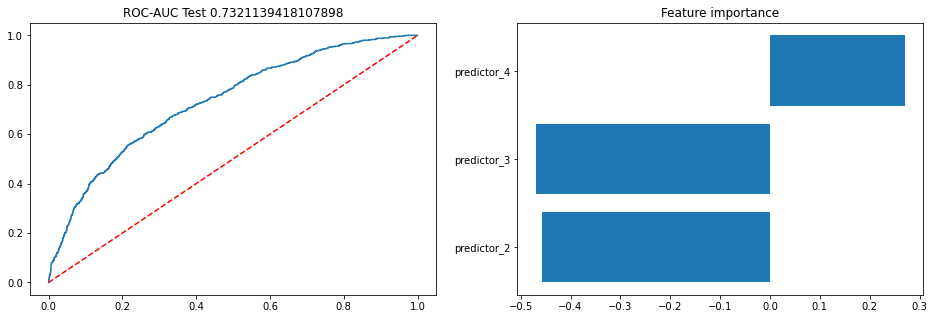

In [17]:
pipe = Pipeline(steps=[
    ('fill_na', KNNImputer(n_neighbors=2)),
    ('scaler', StandardScaler()),
    ('select_features', SelectKBest(k=3)),
    ('classifier', LogisticRegression(**params, random_state=42)),
])

pipe.fit(X_train, y_train)
predict = pipe.predict_proba(X_test)

# Viz
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# ROC-AUC plot
score = metrics.roc_auc_score(y_true=y_test, y_score=predict[:, 1])
fpr, tpr, thresh = metrics.roc_curve(y_test, predict[:, 1])
axes[0].plot(fpr, tpr)
axes[0].plot([0, 1], [0, 1], color='red', linestyle='--')
axes[0].set_title(f'ROC-AUC Test {score}')

# Feature importance plot
importance = pipe['classifier'].coef_[0]
feature_names = X_train.columns[pipe['select_features'].get_support()]
axes[1].barh(feature_names, importance)
axes[1].set_title(f'Feature importance')


# Итоги